## App visits prediction model

고객 데이터로부터 **앱 방문수를 예측**하는 모델  

타겟변수가 visits으로 numerical variable이므로 **regression** 문제이다.

visits과 revenue 사이에는 선후관계가 존재(방문을 해야 매출이 발생)하므로 revenue를 설명변수로 쓰기 위해서는 값을 알고있다는 가정을 해야한다. 하지만 미래의 데이터 추출 시점까지의 revenue를 미리 알고있다는 가정이 타당하지 않으므로, 과거의 데이터로부터 각 사용자의 평균 basket size를 알고있다고 가정하였다.  
즉, 사용하는 설명변수는 marketing_channel, sex, age_group, os, period, basket_size 이고, 타겟변수인 visits을 제외한 나머지 date_joined와 revenue는 삭제해야 한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
import datetime
from collections import Counter

In [2]:
user_info = pd.read_csv('user_info_preprocessed.csv')
user_info = user_info.drop(['date_joined', 'revenue'], axis=1)
user_info.head()

,marketing_channel,sex,age_group,os,visits,period,basket_size
0,channel_A,male,30-39,android,23.0,235,13.217391
1,channel_B,male,20-29,android,5.0,235,38.999992
2,channel_A,male,30-39,android,1.0,220,77.999922
3,channel_A,female,30-39,iOS,18.0,225,11.222222
4,channel_A,male,30-39,android,9.0,225,21.888886


In [3]:
x = user_info[user_info.columns.difference(['visits'])]
print(x.shape)

(436098, 6)


In [4]:
num_feats = x.dtypes[x.dtypes != 'object'].index
cat_feats = x.dtypes[x.dtypes == 'object'].index

설명변수별 타겟변수와의 관계를 heatmap과 boxplot으로 시각화하고, numerical features는 scaling하고 categorical features는 더미변수로 변환한다.

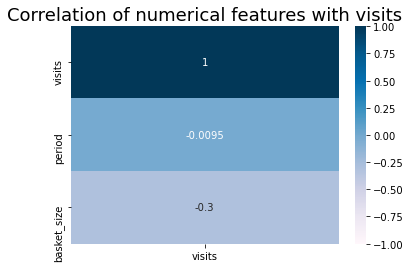

In [5]:
fig, ax = plt.subplots()
plt.title('Correlation of numerical features with visits', y=1, size=18)
sns.heatmap(user_info.corr()[['visits']].sort_values(by='visits', ascending=False), vmin=-1, vmax=1, annot=True, cmap=plt.cm.PuBu)

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x[num_feats])

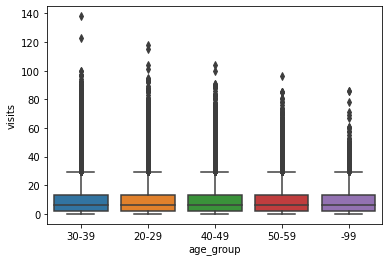

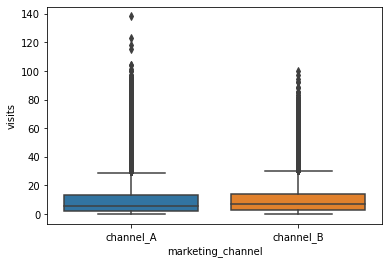

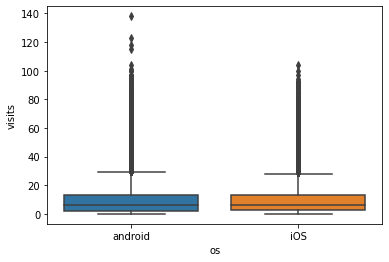

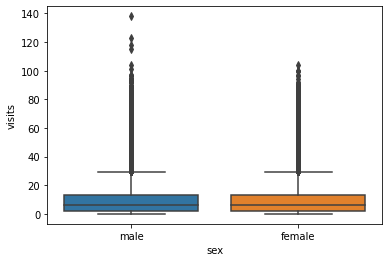

In [7]:
for cat in list(cat_feats):
    sns.boxplot(x=cat, y=user_info['visits'], data=x)
    plt.show()

In [8]:
for cat in list(cat_feats):
    print(x[cat].value_counts())
    print('-'*50)
x_dummy = pd.get_dummies(x, columns=cat_feats, drop_first=True)

30-39    173709
20-29    141862
40-49     84775
50-59     31224
-99        4528
Name: age_group, dtype: int64
--------------------------------------------------
channel_A    357306
channel_B     78792
Name: marketing_channel, dtype: int64
--------------------------------------------------
android    251473
iOS        184625
Name: os, dtype: int64
--------------------------------------------------
male      235477
female    200621
Name: sex, dtype: int64
--------------------------------------------------


In [9]:
x_rev = np.concatenate((x_scaled, x_dummy), axis=1)
print(x_rev.shape)

(436098, 11)


타겟변수인 visits가 왼쪽으로 크게 치우친 데이터이므로, log 변환을 통해 왜도와 첨도를 감소시킨다.

Skewness: 1.987450
Kurtosis: 5.935875


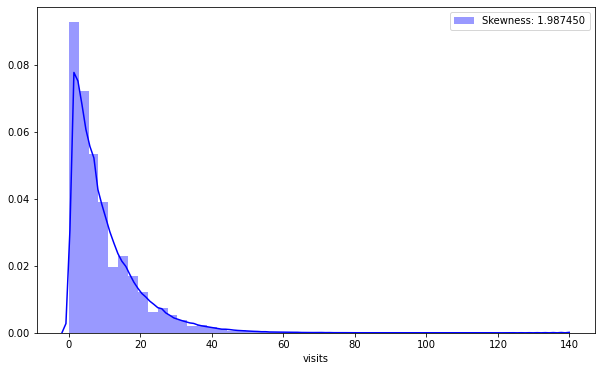

In [10]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
g = sns.distplot(user_info['visits'], color='b', label='Skewness: {:2f}'.format(user_info['visits'].skew()), ax=ax)
g = g.legend(loc='best')
print("Skewness: %f" % user_info['visits'].skew())
print("Kurtosis: %f" % user_info['visits'].kurt())

Skewness: -0.177813
Kurtosis: -0.966878


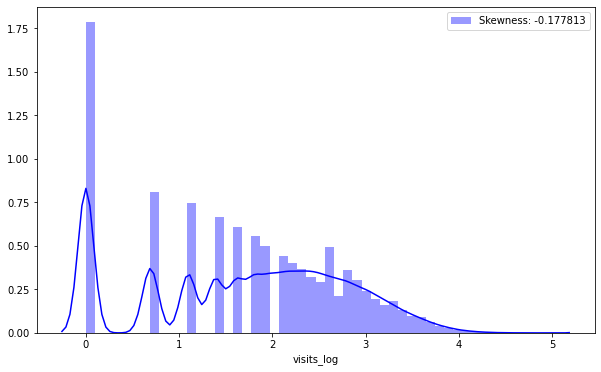

In [11]:
user_info['visits_log'] = user_info['visits'].map(lambda i: np.log(i) if i>0 else 0)

f, ax = plt.subplots(1, 1, figsize=(10, 6))
g = sns.distplot(user_info['visits_log'], color='b', label='Skewness: {:2f}'.format(user_info['visits_log'].skew()), ax=ax)
g = g.legend(loc='best')
print("Skewness: %f" % user_info['visits_log'].skew())
print("Kurtosis: %f" % user_info['visits_log'].kurt())

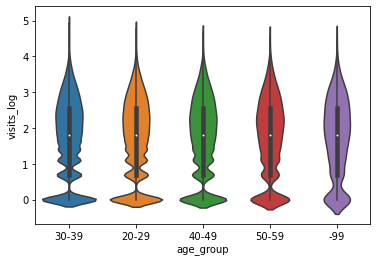

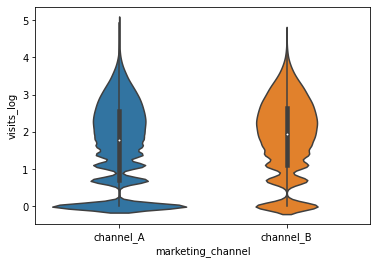

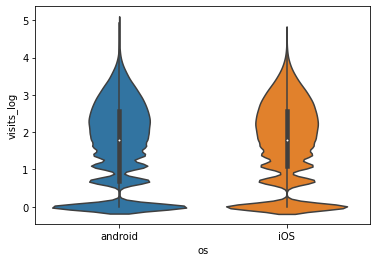

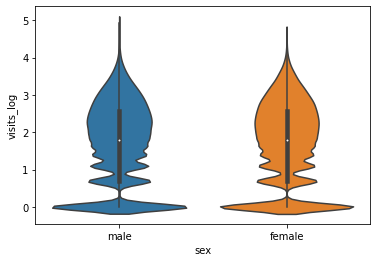

In [12]:
for cat in list(cat_feats):
    sns.violinplot(x=cat, y=user_info['visits_log'], data=x)
    plt.show()

training set과 test set으로 나눈 후, training set을 이용하여 여러 regression 모델의 성능을 비교한다.  
Regression 문제이므로 RMSE를 기준으로 최적의 모델을 선택한다.

In [13]:
from sklearn.model_selection import train_test_split
y = user_info['visits_log']
x_train, x_test, y_train, y_test = train_test_split(x_rev, y, test_size = 0.2, random_state = 1)

In [14]:
from sklearn.model_selection import cross_val_score

def display_scores(model_name, score):
    print('Model: ', model_name)
    print('Scores: ', score)
    print('Mean score: ', score.mean())

In [15]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
tree.fit(x_train, y_train)
score_tree = cross_val_score(tree, x_train, y_train, cv=3, scoring='neg_mean_squared_error') 
display_scores('Decision tree', np.sqrt(-score_tree))

Model:  Decision tree
Scores:  [0.28244437 0.27983573 0.27975155]
Mean score:  0.2806772182021923


In [16]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor()
forest.fit(x_train, y_train)
score_forest = cross_val_score(forest, x_train, y_train, cv=3, scoring='neg_mean_squared_error')
display_scores('Random forest', np.sqrt(-score_forest))

Model:  Random forest
Scores:  [0.23404694 0.23156882 0.23445734]
Mean score:  0.23335769848228793


In [17]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn.fit(x_train, y_train)
score_knn = cross_val_score(knn, x_train, y_train, cv=3, scoring='neg_mean_squared_error')
display_scores('KNN', np.sqrt(-score_knn))

Model:  KNN
Scores:  [0.63165262 0.63102941 0.62957453]
Mean score:  0.630752187419922


In [18]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(x_train, y_train)
score_xgb = cross_val_score(xgb, x_train, y_train, cv=3, scoring='neg_mean_squared_error')
display_scores('XGBoost', np.sqrt(-score_xgb))

Model:  XGBoost
Scores:  [0.45898709 0.45991293 0.45684523]
Mean score:  0.4585817520988225


In [19]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor()
lgbm.fit(x_train, y_train)
score_lgbm = cross_val_score(lgbm, x_train, y_train, cv=3, scoring='neg_mean_squared_error')
display_scores('LightGBM', np.sqrt(-score_lgbm))

Model:  LightGBM
Scores:  [0.55807174 0.55343246 0.55683028]
Mean score:  0.5561114962945225


RMSE가 가장 낮은 Random forest model 을 선택하여, hyperparameter tuning을 진행하였다.

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 1)

In [21]:
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
import time

tic = time.time()
forest = RandomForestRegressor()
param_1 = {'n_estimators':range(10,110,10)}
gridcv = GridSearchCV(forest, param_grid=param_1, cv=3, scoring='neg_mean_squared_error')
gridcv.fit(x_train, y_train)

y_pred = gridcv.predict(x_val)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
toc = time.time()

print(gridcv.best_params_)
print('MAE: {0:.4f}, MSE: {1:.4f}, RMSE: {2:.4f}'.format(mae, mse, rmse))
print('time elapsed:', toc - tic)

{'n_estimators': 100}
MAE: 0.1140, MSE: 0.0498, RMSE: 0.2231
time elapsed: 1067.993626832962


In [22]:
tic = time.time()
forest = RandomForestRegressor()
param_2 = {'n_estimators': [100, 200, 500]}
gridcv = GridSearchCV(forest, param_grid=param_2, cv=3, scoring='neg_mean_squared_error')
gridcv.fit(x_train, y_train)

y_pred = gridcv.predict(x_val)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
toc = time.time()

print(gridcv.best_params_)
print('MAE: {0:.4f}, MSE: {1:.4f}, RMSE: {2:.4f}'.format(mae, mse, rmse))
print('time elapsed:', toc - tic)

{'n_estimators': 500}
MAE: 0.1137, MSE: 0.0495, RMSE: 0.2224
time elapsed: 1849.35014128685


최적의 hyperparameter로 설정한 모델을 학습시켜 test set에 대해 최종 성능을 평가한다.

In [23]:
#after tuning 
forest_after = RandomForestRegressor(n_estimators=500)
forest_after.fit(x_train, y_train)

#final test
y_pred = forest_after.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('MAE: {0:.4f}, MSE: {1:.4f}, RMSE: {2:.4f}'.format(mae, mse, rmse))

MAE: 0.1133, MSE: 0.0488, RMSE: 0.2209
